## Experiment option

1. Try different models: 
- LSTM/GRU Networks: The starter code already includes a simple LSTM model. This is a good starting point as temporal dependencies are important.
- Transformer-based models: Could capture long-range dependencies better than LSTMs.
- Graph Neural Networks (GNNs): Especially useful if you model the skeleton as a graph structure.

2. Bio-mechanical Constraints
- Loss function constraints: Add penalty terms to your loss function that increase when predictions violate biomechanical constraints.
- Post-processing corrections: Apply corrections to predictions that violate constraints.
- Constrained outputs: Use activation functions that limit the output range.

## Load data

In [21]:
import os
import sys
import glob

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
from IPython.display import HTML

In [22]:
filenames = glob.glob('../data/*.npz')
assert len(filenames) > 0, 'No data files found in ./data/'

filename = filenames[0]
data = np.load(filename)
print('Data containing:')
[print(f'Array {f} of shape {data[f].shape}') for f in data.files];

Data containing:
Array time of shape (1002,)
Array leftShoulderPosRel of shape (1002, 3)
Array rightShoulderPosRel of shape (1002, 3)
Array leftElbowPosRel of shape (1002, 3)
Array rightElbowPosRel of shape (1002, 3)
Array leftWristPosRel of shape (1002, 3)
Array rightWristPosRel of shape (1002, 3)
Array leftFingerPosRel of shape (1002, 3)
Array rightFingerPosRel of shape (1002, 3)
Array accelerationLeftLoc of shape (1002, 3)
Array accelerationRightLoc of shape (1002, 3)
Array gyroLeftLoc of shape (1002, 3)
Array gyroRightLoc of shape (1002, 3)


## Visualize data

#### Extract MoCap

In [23]:
def extractMoCap(data):
    time = data['time'] # (T,)
    torso = np.stack([np.zeros_like(data['leftShoulderPosRel']),
                      data['leftShoulderPosRel'],
                      data['rightShoulderPosRel'],
                      np.zeros_like(data['rightShoulderPosRel'])], axis=1) # (T, 4, 3)
    left_arm = np.stack([data['leftShoulderPosRel'],
                         data['leftElbowPosRel'],
                         data['leftWristPosRel'],
                         data['leftFingerPosRel']], axis=1) # (T, 4, 3)
    right_arm = np.stack([data['rightShoulderPosRel'],
                          data['rightElbowPosRel'],
                          data['rightWristPosRel'],
                          data['rightFingerPosRel']], axis=1) # (T, 4, 3)

    return time, torso, left_arm, right_arm

#### Visualize MoCap

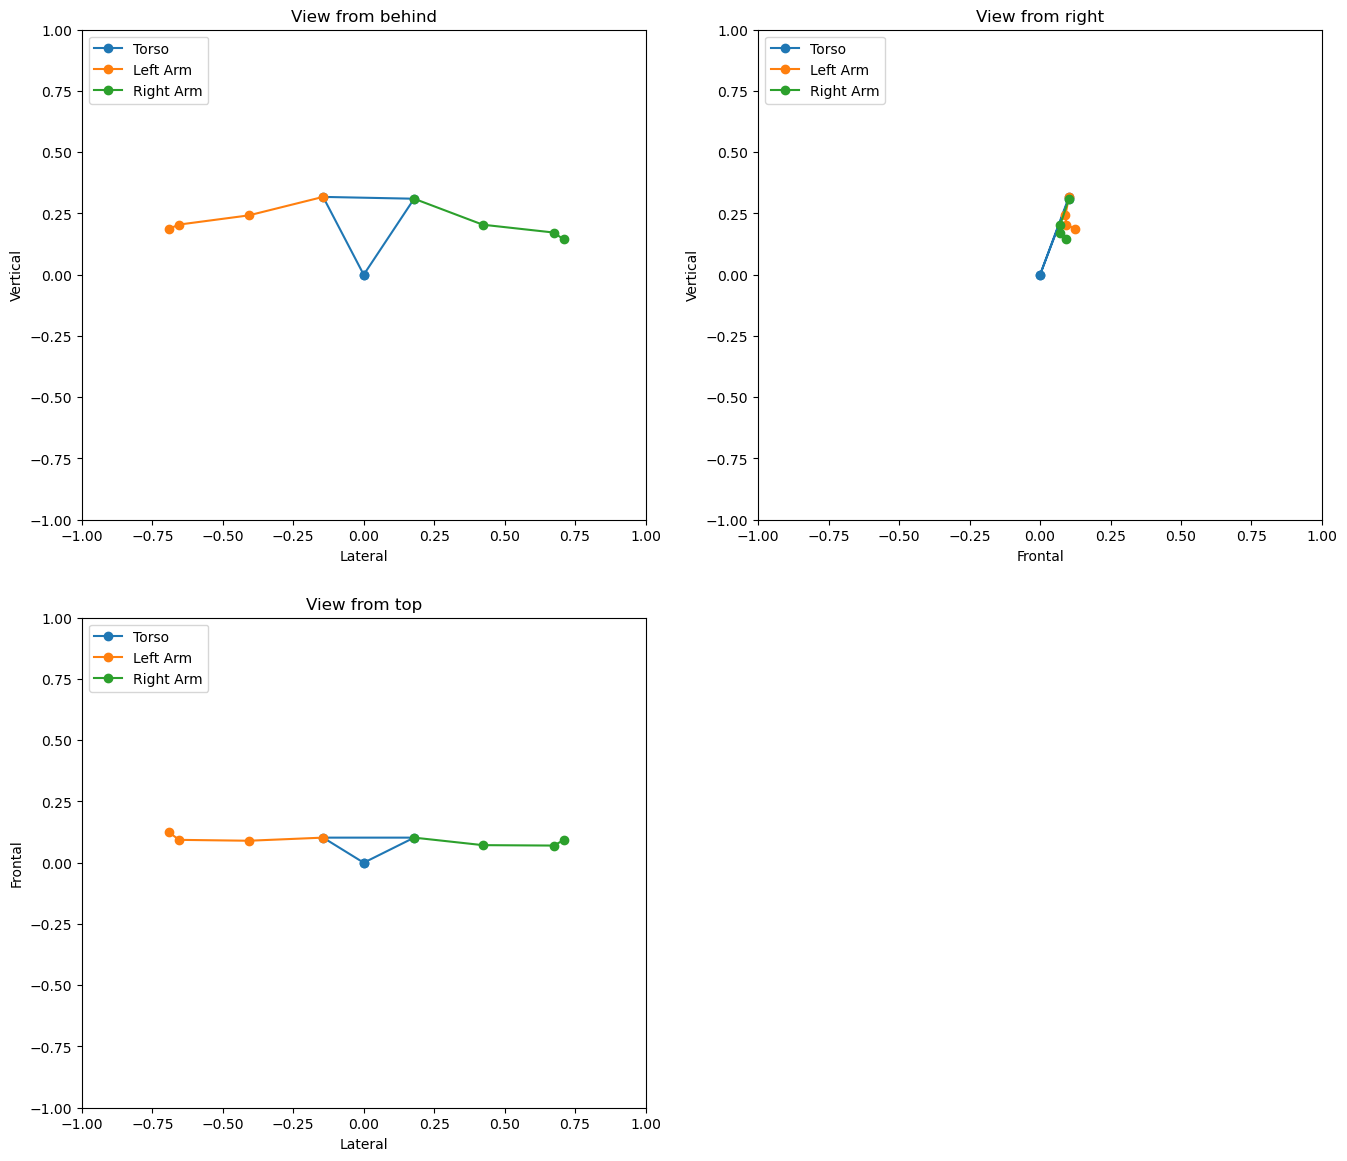

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16,14))

t = 0 # Select frame to observe
time, torso, left_arm, right_arm = extractMoCap(data)

[ax[i,j].set_xlim(-1,1) for i in range(2) for j in range(2)]
[ax[i,j].set_ylim(-1,1) for i in range(2) for j in range(2)]

ax[0,0].set_title('View from behind')
ax[0,0].set_xlabel('Lateral')
ax[0,0].set_ylabel('Vertical')
t_00, = ax[0,0].plot(torso[t,:,0], torso[t,:,2], '-o', label='Torso')
l_00, = ax[0,0].plot(left_arm[t,:,0], left_arm[t,:,2], '-o', label='Left Arm')
r_00, = ax[0,0].plot(right_arm[t,:,0], right_arm[t,:,2], '-o', label='Right Arm')
ax[0,0].legend(loc='upper left')

ax[0,1].set_title('View from right')
ax[0,1].set_xlabel('Frontal')
ax[0,1].set_ylabel('Vertical')
t_01, = ax[0,1].plot(torso[t,:,1], torso[t,:,2], '-o', label='Torso')
l_01, = ax[0,1].plot(left_arm[t,:,1], left_arm[t,:,2], '-o', label='Left Arm')
r_01, = ax[0,1].plot(right_arm[t,:,1], right_arm[t,:,2], '-o', label='Right Arm')
ax[0,1].legend(loc='upper left')

ax[1,0].set_title('View from top')
ax[1,0].set_xlabel('Lateral')
ax[1,0].set_ylabel('Frontal')
t_10, = ax[1,0].plot(torso[t,:,0], torso[t,:,1], '-o', label='Torso')
l_10, = ax[1,0].plot(left_arm[t,:,0], left_arm[t,:,1], '-o', label='Left Arm')
r_10, = ax[1,0].plot(right_arm[t,:,0], right_arm[t,:,1], '-o', label='Right Arm')
ax[1,0].legend(loc='upper left')

ax[1,1].set_axis_off()

#### Extract IMU

In [25]:
def extractIMU(data):
    time = data['time'] # (T,)
    left_acc = data['accelerationLeftLoc'] # (T, 3)
    right_acc = data['accelerationRightLoc'] # (T, 3)
    left_gyro = data['gyroLeftLoc'] # (T, 3)
    right_gyro = data['gyroRightLoc'] # (T, 3)

    return time, left_acc, right_acc, left_gyro, right_gyro

#### Visualize IMU

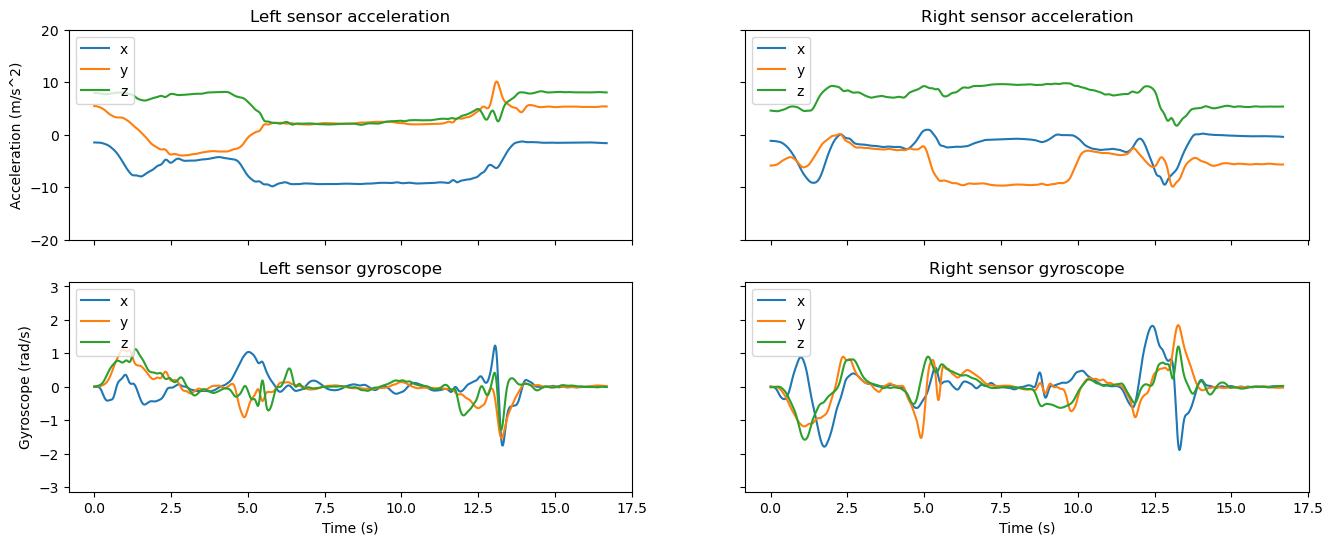

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(16,6), sharex=True, sharey='row')

time, left_acc, right_acc, left_gyro, right_gyro = extractIMU(data)

ax[0,0].set_ylim(-20,20)
ax[1,0].set_ylim(-np.pi,np.pi)

ax[0,0].set_title('Left sensor acceleration')
ax[0,0].set_ylabel('Acceleration (m/s^2)')
ax[0,0].plot(time, left_acc, label=['x', 'y', 'z'])
ax[0,0].legend(loc='upper left')

ax[0,1].set_title('Right sensor acceleration')
ax[0,1].plot(time, right_acc, label=['x', 'y', 'z'])
ax[0,1].legend(loc='upper left')

ax[1,0].set_title('Left sensor gyroscope')
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Gyroscope (rad/s)')
ax[1,0].plot(time, left_gyro, label=['x', 'y', 'z'])
ax[1,0].legend(loc='upper left')

ax[1,1].set_title('Right sensor gyroscope')
ax[1,1].set_xlabel('Time (s)')
ax[1,1].plot(time, right_gyro, label=['x', 'y', 'z'])
ax[1,1].legend(loc='upper left')

## Create PyTorch dataset

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

#### Create custom dataset class

In [28]:
class CustomDataset(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        data = np.load(filename)
        time, torso, left_arm, right_arm = extractMoCap(data)
        time, left_acc, right_acc, left_gyro, right_gyro = extractIMU(data)

        mocap = np.concatenate([left_arm, right_arm], axis=1) # (T, 8, 3)
        imu = np.stack([left_acc, right_acc, left_gyro, right_gyro], axis=1) # (T, 4, 3)

        return {'time': torch.tensor(time, dtype=torch.float32),
                'mocap': torch.tensor(mocap, dtype=torch.float32),
                'imu': torch.tensor(imu, dtype=torch.float32)}

#### Get subjects

In [29]:
subjects = np.unique([f.split('_')[-2] for f in filenames])

print(f'Found subjects: {subjects}')

Found subjects: ['s1' 's10' 's2' 's3' 's4' 's5' 's6' 's7' 's8' 's9']


#### Split train/test using LOSO

In [30]:
#permutation = np.random.permutation(len(subjects))
#train_subjects = subjects[permutation[:-1]]
#test_subjects = subjects[permutation[-1:]]

np.random.seed(42)  # Fix random seed

permutation = np.random.permutation(len(subjects))
train_subjects = subjects[permutation[:-1]]
test_subjects = subjects[permutation[-1:]]

print(f'Training on subjects: {train_subjects}')
print(f'Testing on subjects: {test_subjects}')

Training on subjects: ['s8' 's10' 's5' 's1' 's7' 's2' 's9' 's4' 's3']
Testing on subjects: ['s6']


#### Instantiate datasets

In [31]:
train_dataset = CustomDataset([f for f in filenames if any(s == f.split('_')[-2] for s in train_subjects)])
test_dataset = CustomDataset([f for f in filenames if any(s == f.split('_')[-2] for s in test_subjects)])

#### Collate function to deal with different lengths

In [32]:
def collate_fn(batch):
    longest_sample = max(batch, key=lambda x: len(x['time']))
    max_len = len(longest_sample['time']) # max_len
    padded_batch = []

    for sample in batch:
        padding_len = max_len - len(sample['time'])
        padded_sample = {}
        padded_sample['mocap'] = torch.cat([sample['mocap'],
                                            sample['mocap'][-1:].repeat(padding_len,1,1)]) # (max_len, 8, 3)
        acc = torch.cat([sample['imu'][:,[0,1]],
                         sample['imu'][-1:,[0,1]].repeat(padding_len,1,1)]) # (max_len, 2, 3)
        gyro = torch.cat([sample['imu'][:,[2,3]],
                          torch.zeros_like(sample['imu'][-1:,[2,3]]).repeat(padding_len,1,1)]) # (max_len, 2, 3)
        padded_sample['imu'] = torch.cat([acc, gyro], dim=1) # (max_len, 4, 3)
        padded_batch.append(padded_sample)

    return {'time': longest_sample['time'],
            'mocap': torch.stack([sample['mocap'] for sample in padded_batch]),
            'imu': torch.stack([sample['imu'] for sample in padded_batch])}

#### Instantiate dataloaders

In [33]:
batch_size = 10

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

## Train model

#### Define architecture

In [34]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=4*3, hidden_size=8*3, num_layers=2):
        super(SimpleNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

    def forward(self, x):
        x = x.flatten(2) # (N, T, 12)
        out, _ = self.lstm(x) # (N, T, 24)
        return out

#### Instantiate model

In [35]:
model = SimpleNN(input_size=4*3, hidden_size=8*3, num_layers=2)

#### Define criterion

In [36]:
criterion = nn.MSELoss()

### ⭐ Bio-mechanical constraints

In [37]:
def angle_constraint_loss(predictions, alpha=0.1, min_angle = 30, max_angle=180):
    """
    Joint angle constraint loss.
    - Computes actual angles using arccos and penalizes any values that fall outside the natural range (min_angle, max_angle).
    - Angles are converted to degrees for comparison.
    """
    # Extract left/right arm joints from predictions with shape (batch_size, seq_len, 8, 3)
    # Joint order is assumed as:
    # [left_shoulder, left_elbow, left_wrist, left_finger, right_shoulder, right_elbow, right_wrist, right_finger]
    left_shoulder = predictions[:, :, 0, :]
    left_elbow = predictions[:, :, 1, :]
    left_wrist = predictions[:, :, 2, :]
    
    right_shoulder = predictions[:, :, 4, :]
    right_elbow = predictions[:, :, 5, :]
    right_wrist = predictions[:, :, 6, :]
    
    # Compute vectors between joints
    left_upper = left_elbow - left_shoulder
    left_fore = left_wrist - left_elbow
    right_upper = right_elbow - right_shoulder
    right_fore = right_wrist - right_elbow
    
    # Normalize the vectors
    left_upper_norm = F.normalize(left_upper, p=2, dim=-1)
    left_fore_norm = F.normalize(left_fore, p=2, dim=-1)
    right_upper_norm = F.normalize(right_upper, p=2, dim=-1)
    right_fore_norm = F.normalize(right_fore, p=2, dim=-1)
    
    # Compute cosine similarity and clamp for numerical stability
    left_cosine = torch.clamp(torch.sum(left_upper_norm * left_fore_norm, dim=-1), -1.0, 1.0)
    right_cosine = torch.clamp(torch.sum(right_upper_norm * right_fore_norm, dim=-1), -1.0, 1.0)
    
    # Convert angles from radians to degrees
    left_angles = torch.acos(left_cosine) * 180.0 / torch.pi
    right_angles = torch.acos(right_cosine) * 180.0 / torch.pi
    
    # Compute penalty for values outside the allowable range
    left_penalty = torch.clamp(left_angles - max_angle, min=0) + torch.clamp(min_angle - left_angles, min=0)
    right_penalty = torch.clamp(right_angles - max_angle, min=0) + torch.clamp(min_angle - right_angles, min=0)
    
    # Average penalty across batch and sequence
    total_penalty = torch.mean(left_penalty) + torch.mean(right_penalty)
    
    return alpha * total_penalty

In [38]:
def bone_length_consistency_loss(predictions, alpha=0.1):
    """
    Calculate loss for bone length consistency
    Ensures bone lengths remain constant over time
    """
    # Extract the joint positions
    left_shoulders = predictions[:, :, 0, :]
    left_elbows = predictions[:, :, 1, :]
    left_wrists = predictions[:, :, 2, :]
    left_fingers = predictions[:, :, 3, :]
    
    right_shoulders = predictions[:, :, 4, :]
    right_elbows = predictions[:, :, 5, :]
    right_wrists = predictions[:, :, 6, :]
    right_fingers = predictions[:, :, 7, :]
    
    # Calculate bone vectors
    left_upper_arm = left_elbows - left_shoulders
    left_forearm = left_wrists - left_elbows
    left_hand = left_fingers - left_wrists
    
    right_upper_arm = right_elbows - right_shoulders
    right_forearm = right_wrists - right_elbows  
    right_hand = right_fingers - right_wrists
    
    # Calculate bone lengths at each time step
    left_upper_arm_lengths = torch.sqrt(torch.sum(left_upper_arm**2, dim=-1))
    left_forearm_lengths = torch.sqrt(torch.sum(left_forearm**2, dim=-1))
    left_hand_lengths = torch.sqrt(torch.sum(left_hand**2, dim=-1))
    
    right_upper_arm_lengths = torch.sqrt(torch.sum(right_upper_arm**2, dim=-1))
    right_forearm_lengths = torch.sqrt(torch.sum(right_forearm**2, dim=-1))
    right_hand_lengths = torch.sqrt(torch.sum(right_hand**2, dim=-1))
    
    # Calculate variance of bone lengths over time (for each sequence in batch)
    left_upper_arm_var = torch.var(left_upper_arm_lengths, dim=1)
    left_forearm_var = torch.var(left_forearm_lengths, dim=1)
    left_hand_var = torch.var(left_hand_lengths, dim=1)
    
    right_upper_arm_var = torch.var(right_upper_arm_lengths, dim=1)
    right_forearm_var = torch.var(right_forearm_lengths, dim=1)
    right_hand_var = torch.var(right_hand_lengths, dim=1)
    
    # Calculate total variance (average across batch)
    total_var = (torch.mean(left_upper_arm_var) + 
                torch.mean(left_forearm_var) + 
                torch.mean(left_hand_var) +
                torch.mean(right_upper_arm_var) + 
                torch.mean(right_forearm_var) + 
                torch.mean(right_hand_var))
    
    return alpha * total_var

#### Initialize optimizer

In [39]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Run epochs

In [40]:
import torch.nn.functional as F

# Make sure to import necessary libraries
num_epochs = 25  # More epochs for better training

# ⭐ Define loss weights
angle_weight = 0.1
bone_length_weight = 0.2

# Create a dictionary to store metrics
metrics = {
    'train_loss': [],
    'test_loss': [],
    'train_mse': [],
    'test_mse': [],
    'train_angle': [],
    'test_angle': [],
    'train_bone': [],
    'test_bone': []
}

for epoch in range(num_epochs):
    print(f'Running epoch [{epoch+1}/{num_epochs}]')
    
    # Training loop
    model.train()
    epoch_train_loss = 0
    epoch_train_mse = 0
    epoch_train_angle = 0
    epoch_train_bone = 0
    
    for i, batch in enumerate(train_dataloader):
        # Forward pass
        outputs = model(batch['imu'])
        outputs_reshaped = outputs.view(*batch['mocap'].shape)
        
        # Calculate different loss components
        mse_loss = F.mse_loss(outputs_reshaped, batch['mocap'])
        angle_loss = angle_constraint_loss(outputs_reshaped, alpha=angle_weight)
        bone_loss = bone_length_consistency_loss(outputs_reshaped, alpha=bone_length_weight)
        
        # ⭐ Combine losses
        total_loss = mse_loss + angle_loss + bone_loss
        
        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Accumulate losses
        epoch_train_loss += total_loss.item()
        epoch_train_mse += mse_loss.item()
        epoch_train_angle += angle_loss.item()
        epoch_train_bone += bone_loss.item()
        
        if (i+1) % 10 == 0:
            print(f'Train Step [{i+1}/{len(train_dataloader)}], Total Loss: {total_loss.item():.4f}, '
                  f'MSE: {mse_loss.item():.4f}, Angle: {angle_loss.item():.4f}, Bone: {bone_loss.item():.4f}')
    
    # Average losses for the epoch
    epoch_train_loss /= len(train_dataloader)
    epoch_train_mse /= len(train_dataloader)
    epoch_train_angle /= len(train_dataloader)
    epoch_train_bone /= len(train_dataloader)
    
    # Store metrics
    metrics['train_loss'].append(epoch_train_loss)
    metrics['train_mse'].append(epoch_train_mse)
    metrics['train_angle'].append(epoch_train_angle)
    metrics['train_bone'].append(epoch_train_bone)
    
    # Evaluation loop
    model.eval()
    epoch_test_loss = 0
    epoch_test_mse = 0
    epoch_test_angle = 0
    epoch_test_bone = 0
    
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            # Forward pass
            outputs = model(batch['imu'])
            outputs_reshaped = outputs.view(*batch['mocap'].shape)
            
            # Calculate different loss components
            mse_loss = F.mse_loss(outputs_reshaped, batch['mocap'])
            angle_loss = angle_constraint_loss(outputs_reshaped, alpha=angle_weight)
            bone_loss = bone_length_consistency_loss(outputs_reshaped, alpha=bone_length_weight)
            
            # Combine losses
            total_loss = mse_loss + angle_loss + bone_loss
            
            # Accumulate losses
            epoch_test_loss += total_loss.item()
            epoch_test_mse += mse_loss.item()
            epoch_test_angle += angle_loss.item()
            epoch_test_bone += bone_loss.item()
            
            if (i+1) % 10 == 0:
                print(f'Test Step [{i+1}/{len(test_dataloader)}], Total Loss: {total_loss.item():.4f}, '
                      f'MSE: {mse_loss.item():.4f}, Angle: {angle_loss.item():.4f}, Bone: {bone_loss.item():.4f}')
    
    # Average losses for the epoch
    epoch_test_loss /= len(test_dataloader)
    epoch_test_mse /= len(test_dataloader)
    epoch_test_angle /= len(test_dataloader)
    epoch_test_bone /= len(test_dataloader)
    
    # Store metrics
    metrics['test_loss'].append(epoch_test_loss)
    metrics['test_mse'].append(epoch_test_mse)
    metrics['test_angle'].append(epoch_test_angle)
    metrics['test_bone'].append(epoch_test_bone)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')
    
    # Save model checkpoint if desired
    if epoch % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_test_loss,
            'metrics': metrics
        }, f'checkpoint_epoch_{epoch}.pth')

Running epoch [1/25]
Train Step [10/120], Total Loss: 0.1160, MSE: 0.1055, Angle: 0.0056, Bone: 0.0048
Train Step [20/120], Total Loss: 0.1041, MSE: 0.0822, Angle: 0.0160, Bone: 0.0060
Train Step [30/120], Total Loss: 0.0750, MSE: 0.0707, Angle: 0.0002, Bone: 0.0041
Train Step [40/120], Total Loss: 0.0742, MSE: 0.0690, Angle: 0.0007, Bone: 0.0045
Train Step [50/120], Total Loss: 0.0664, MSE: 0.0625, Angle: 0.0001, Bone: 0.0038
Train Step [60/120], Total Loss: 0.0611, MSE: 0.0578, Angle: 0.0000, Bone: 0.0033
Train Step [70/120], Total Loss: 0.0540, MSE: 0.0499, Angle: 0.0002, Bone: 0.0040
Train Step [80/120], Total Loss: 0.0485, MSE: 0.0456, Angle: 0.0000, Bone: 0.0028
Train Step [90/120], Total Loss: 0.0398, MSE: 0.0372, Angle: 0.0000, Bone: 0.0026
Train Step [100/120], Total Loss: 0.0408, MSE: 0.0375, Angle: 0.0002, Bone: 0.0031
Train Step [110/120], Total Loss: 0.0372, MSE: 0.0353, Angle: 0.0000, Bone: 0.0019
Train Step [120/120], Total Loss: 0.0443, MSE: 0.0431, Angle: 0.0000, Bone:

In [42]:
torch.save(model.state_dict(), './BASE_LSTM_epoch_25.pth')

### ⭐ Calculate MPJPE (Mean Per Joint Position Error) / MPVE (Mean Per Joint Velocity Error)
- Goal: MPJPE < 0.10~0.20 m (10–20cm), MPVE < ~1cm/s 

In [43]:
def compute_mpjpe(predictions, targets):
    """
    predictions, targets: (B, T, J, 3)
    Returns: scalar MPJPE (in meters)
    """
    error = torch.norm(predictions - targets, dim=-1)  # (B, T, J)
    return error.mean().item()

def compute_mpve(predictions, targets):
    """
    predictions, targets: (B, T, J, 3)
    Returns: scalar MPVE (in m/s)
    """
    pred_velocity = predictions[:, 1:, :, :] - predictions[:, :-1, :, :]  # (B, T-1, J, 3)
    target_velocity = targets[:, 1:, :, :] - targets[:, :-1, :, :]        # (B, T-1, J, 3)

    velocity_error = torch.norm(pred_velocity - target_velocity, dim=-1)  # (B, T-1, J)
    return velocity_error.mean().item()

In [ ]:
# Evaluation loop
model.eval()

# Initialize accumulators
epoch_test_loss = 0
epoch_test_mse = 0
epoch_test_angle = 0
epoch_test_bone = 0
epoch_test_mpjpe = 0
epoch_test_mpve = 0

metrics = {
    'train_loss': [],
    'test_loss': [],
    'train_mse': [],
    'test_mse': [],
    'train_angle': [],
    'test_angle': [],
    'train_bone': [],
    'test_bone': [],
     'test_mpjpe': [],  
    'test_mpve': []
}

with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        # Forward pass
        outputs = model(batch['imu'])  # Shape: (B, T*J*3)
        outputs_reshaped = outputs.view(*batch['mocap'].shape)  # (B, T, J, 3)

        # Loss components
        mse_loss = F.mse_loss(outputs_reshaped, batch['mocap'])
        angle_loss = angle_constraint_loss(outputs_reshaped, alpha=angle_weight)
        bone_loss = bone_length_consistency_loss(outputs_reshaped, alpha=bone_length_weight)
        total_loss = mse_loss + angle_loss + bone_loss

        # Accumulate losses
        epoch_test_loss += total_loss.item()
        epoch_test_mse += mse_loss.item()
        epoch_test_angle += angle_loss.item()
        epoch_test_bone += bone_loss.item()

        # ➕ Compute MPJPE and MPVE
        epoch_test_mpjpe += compute_mpjpe(outputs_reshaped, batch['mocap'])
        epoch_test_mpve += compute_mpve(outputs_reshaped, batch['mocap'])

        if (i + 1) % 10 == 0:
            print(f'Test Step [{i+1}/{len(test_dataloader)}], '
                  f'Total Loss: {total_loss.item():.4f}, '
                  f'MSE: {mse_loss.item():.4f}, '
                  f'Angle: {angle_loss.item():.4f}, '
                  f'Bone: {bone_loss.item():.4f}')

# Average over all batches
epoch_test_loss /= len(test_dataloader)
epoch_test_mse /= len(test_dataloader)
epoch_test_angle /= len(test_dataloader)
epoch_test_bone /= len(test_dataloader)
epoch_test_mpjpe /= len(test_dataloader)
epoch_test_mpve /= len(test_dataloader)

# Store metrics
metrics['test_loss'].append(epoch_test_loss)
metrics['test_mse'].append(epoch_test_mse)
metrics['test_angle'].append(epoch_test_angle)
metrics['test_bone'].append(epoch_test_bone)
metrics['test_mpjpe'].append(epoch_test_mpjpe)
metrics['test_mpve'].append(epoch_test_mpve)

# Summary
print(f'Epoch [{epoch+1}/{num_epochs}], '
      f'Test Loss: {epoch_test_loss:.4f}, '
      f'MPJPE: {epoch_test_mpjpe:.4f}, '
      f'MPVE: {epoch_test_mpve:.4f}')


### ⭐ Evaluate Model performance

In [ ]:
# after outputs_reshaped is computed
mpjpe = compute_mpjpe(outputs_reshaped, batch['mocap'])
mpve = compute_mpve(outputs_reshaped, batch['mocap'])

epoch_test_mpjpe += mpjpe
epoch_test_mpve += mpve

print(epoch_test_mpjpe)
print(epoch_test_mpve)

### ⭐ Visualize a result

In [46]:
def visualize_skeleton_comparison(ground_truth, predictions, frame_idx=0, title='Skeleton Comparison'):
    """
    Visualize ground truth vs predicted skeletons
    
    Args:
        ground_truth: Tensor of shape (seq_len, 8, 3) or array-like
        predictions: Tensor of shape (seq_len, 8, 3) or array-like
        frame_idx: Index of the frame to visualize
        title: Plot title
    """
    # Convert to numpy if tensors
    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.detach().cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    
    # Extract specific frame
    gt_frame = ground_truth[frame_idx]  # Shape: (8, 3)
    pred_frame = predictions[frame_idx]  # Shape: (8, 3)
    
    # Define the connections for visualization (joint indices)
    left_arm_connections = [(0, 1), (1, 2), (2, 3)]  # Shoulder -> Elbow -> Wrist -> Finger
    right_arm_connections = [(4, 5), (5, 6), (6, 7)]  # Shoulder -> Elbow -> Wrist -> Finger
    
    fig = plt.figure(figsize=(18, 6))
    
    # Setup 3 views: front (XZ), side (YZ), top (XY)
    views = [(0, 2, 'Front View (XZ)'), (1, 2, 'Side View (YZ)'), (0, 1, 'Top View (XY)')]
    
    for i, (dim1, dim2, view_title) in enumerate(views):
        ax = fig.add_subplot(1, 3, i+1)
        ax.set_title(f"{view_title}")
        
        # Plot ground truth left arm
        for start_idx, end_idx in left_arm_connections:
            ax.plot([gt_frame[start_idx, dim1], gt_frame[end_idx, dim1]], 
                    [gt_frame[start_idx, dim2], gt_frame[end_idx, dim2]], 
                    'b-', linewidth=3, alpha=0.7)
        
        # Plot ground truth right arm
        for start_idx, end_idx in right_arm_connections:
            ax.plot([gt_frame[start_idx, dim1], gt_frame[end_idx, dim1]], 
                    [gt_frame[start_idx, dim2], gt_frame[end_idx, dim2]], 
                    'g-', linewidth=3, alpha=0.7)
        
        # Plot predicted left arm
        for start_idx, end_idx in left_arm_connections:
            ax.plot([pred_frame[start_idx, dim1], pred_frame[end_idx, dim1]], 
                    [pred_frame[start_idx, dim2], pred_frame[end_idx, dim2]], 
                    'b--', linewidth=2)
        
        # Plot predicted right arm
        for start_idx, end_idx in right_arm_connections:
            ax.plot([pred_frame[start_idx, dim1], pred_frame[end_idx, dim1]], 
                    [pred_frame[start_idx, dim2], pred_frame[end_idx, dim2]], 
                    'g--', linewidth=2)
        
        # Plot joints
        ax.scatter(gt_frame[:4, dim1], gt_frame[:4, dim2], c='blue', s=50, label='GT Left Arm')
        ax.scatter(gt_frame[4:, dim1], gt_frame[4:, dim2], c='green', s=50, label='GT Right Arm')
        ax.scatter(pred_frame[:4, dim1], pred_frame[:4, dim2], c='cyan', s=30, label='Pred Left Arm')
        ax.scatter(pred_frame[4:, dim1], pred_frame[4:, dim2], c='lime', s=30, label='Pred Right Arm')
        
        # Set the aspect ratio to be equal
        ax.set_aspect('equal')
        
        # Set labels
        ax.set_xlabel(f"Dimension {dim1}")
        ax.set_ylabel(f"Dimension {dim2}")
        
        # Add legend
        if i == 0:
            ax.legend(loc='upper left')  # or 'best' or 'lower left', etc.

        
        # Add grid
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    
    return fig

In [47]:
import matplotlib.animation as animation
from IPython.display import HTML

def create_skeleton_animation(ground_truth, predictions, save_path=None, fps=30, duration=None):
    """
    Create animation comparing ground truth and predicted skeletons
    
    Args:
        ground_truth: Tensor of shape (seq_len, 8, 3) or array-like
        predictions: Tensor of shape (seq_len, 8, 3) or array-like
        save_path: Path to save the animation. If None, the animation is not saved
        fps: Frames per second
        duration: Duration of the animation in seconds. If None, all frames are used
    
    Returns:
        Animation object that can be displayed in a notebook
    """
    # Convert to numpy if tensors
    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.detach().cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    
    # Define the connections for visualization
    left_arm_connections = [(0, 1), (1, 2), (2, 3)]  # Shoulder -> Elbow -> Wrist -> Finger
    right_arm_connections = [(4, 5), (5, 6), (6, 7)]  # Shoulder -> Elbow -> Wrist -> Finger
    
    # Calculate the total number of frames to display
    total_frames = len(ground_truth)
    if duration is not None:
        total_frames = min(total_frames, int(duration * fps))
    
    # Create figure and axes
    fig = plt.figure(figsize=(18, 6))
    axes = [fig.add_subplot(1, 3, i+1) for i in range(3)]
    
    # Set view titles
    view_titles = ['Front View (XZ)', 'Side View (YZ)', 'Top View (XY)']
    views = [(0, 2), (1, 2), (0, 1)]  # Dimensions to plot for each view
    
    for ax, title in zip(axes, view_titles):
        ax.set_title(title)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
    
    # Set axis limits based on the data range with some padding
    pad = 0.1
    min_vals = np.min(np.concatenate([ground_truth, predictions]), axis=(0, 1))
    max_vals = np.max(np.concatenate([ground_truth, predictions]), axis=(0, 1))
    range_vals = max_vals - min_vals
    min_vals -= range_vals * pad
    max_vals += range_vals * pad
    
    for i, ax in enumerate(axes):
        dim1, dim2 = views[i]
        ax.set_xlim(min_vals[dim1], max_vals[dim1])
        ax.set_ylim(min_vals[dim2], max_vals[dim2])
    
    # Initialize lines and points for ground truth
    gt_left_lines = [[ax.plot([], [], 'b-', linewidth=3, alpha=0.7)[0] for _ in left_arm_connections] for ax in axes]
    gt_right_lines = [[ax.plot([], [], 'g-', linewidth=3, alpha=0.7)[0] for _ in right_arm_connections] for ax in axes]
    gt_left_points = [ax.scatter([], [], c='blue', s=50, label='GT Left Arm') for ax in axes]
    gt_right_points = [ax.scatter([], [], c='green', s=50, label='GT Right Arm') for ax in axes]
    
    # Initialize lines and points for predictions
    pred_left_lines = [[ax.plot([], [], 'b--', linewidth=2)[0] for _ in left_arm_connections] for ax in axes]
    pred_right_lines = [[ax.plot([], [], 'g--', linewidth=2)[0] for _ in right_arm_connections] for ax in axes]
    pred_left_points = [ax.scatter([], [], c='cyan', s=30, label='Pred Left Arm') for ax in axes]
    pred_right_points = [ax.scatter([], [], c='lime', s=30, label='Pred Right Arm') for ax in axes]
    
    # Add legend to the first axis
    axes[0].legend(loc='upper right')
    
    # Frame counter text
    frame_text = fig.text(0.5, 0.95, '', ha='center')
    
    def init():
        """Initialize the animation"""
        for ax_gt_left_lines in gt_left_lines:
            for line in ax_gt_left_lines:
                line.set_data([], [])
        
        for ax_gt_right_lines in gt_right_lines:
            for line in ax_gt_right_lines:
                line.set_data([], [])
        
        for ax_pred_left_lines in pred_left_lines:
            for line in ax_pred_left_lines:
                line.set_data([], [])
        
        for ax_pred_right_lines in pred_right_lines:
            for line in ax_pred_right_lines:
                line.set_data([], [])
        
        for point in gt_left_points + gt_right_points + pred_left_points + pred_right_points:
            point.set_offsets(np.empty((0, 2)))
        
        frame_text.set_text('')
        
        return (sum(gt_left_lines, []) + sum(gt_right_lines, []) + 
                sum(pred_left_lines, []) + sum(pred_right_lines, []) + 
                gt_left_points + gt_right_points + pred_left_points + pred_right_points + 
                [frame_text])
    
    def update(frame_idx):
        """Update the animation for a specific frame"""
        gt_frame = ground_truth[frame_idx]
        pred_frame = predictions[frame_idx]
        
        # Update ground truth lines and points
        for i, ax in enumerate(axes):
            dim1, dim2 = views[i]
            
            # Update ground truth left arm
            for j, (start_idx, end_idx) in enumerate(left_arm_connections):
                gt_left_lines[i][j].set_data(
                    [gt_frame[start_idx, dim1], gt_frame[end_idx, dim1]],
                    [gt_frame[start_idx, dim2], gt_frame[end_idx, dim2]]
                )
            
            # Update ground truth right arm
            for j, (start_idx, end_idx) in enumerate(right_arm_connections):
                gt_right_lines[i][j].set_data(
                    [gt_frame[start_idx, dim1], gt_frame[end_idx, dim1]],
                    [gt_frame[start_idx, dim2], gt_frame[end_idx, dim2]]
                )
            
            # Update predicted left arm
            for j, (start_idx, end_idx) in enumerate(left_arm_connections):
                pred_left_lines[i][j].set_data(
                    [pred_frame[start_idx, dim1], pred_frame[end_idx, dim1]],
                    [pred_frame[start_idx, dim2], pred_frame[end_idx, dim2]]
                )
            
            # Update predicted right arm
            for j, (start_idx, end_idx) in enumerate(right_arm_connections):
                pred_right_lines[i][j].set_data(
                    [pred_frame[start_idx, dim1], pred_frame[end_idx, dim1]],
                    [pred_frame[start_idx, dim2], pred_frame[end_idx, dim2]]
                )
            
            # Update points
            gt_left_points[i].set_offsets(gt_frame[:4, [dim1, dim2]])
            gt_right_points[i].set_offsets(gt_frame[4:, [dim1, dim2]])
            pred_left_points[i].set_offsets(pred_frame[:4, [dim1, dim2]])
            pred_right_points[i].set_offsets(pred_frame[4:, [dim1, dim2]])
        
        # Update frame counter
        frame_text.set_text(f'Frame: {frame_idx+1}/{total_frames}')
        
        return (sum(gt_left_lines, []) + sum(gt_right_lines, []) + 
                sum(pred_left_lines, []) + sum(pred_right_lines, []) + 
                gt_left_points + gt_right_points + pred_left_points + pred_right_points + 
                [frame_text])
    
    # Create the animation
    ani = animation.FuncAnimation(
        fig, update, frames=total_frames, init_func=init, 
        blit=True, interval=1000/fps, repeat=True
    )
    
    # Save animation if a path is provided
    if save_path is not None:
        writer = animation.FFMpegWriter(fps=fps)
        ani.save(save_path, writer=writer)
        print(f"Animation saved to {save_path}")
    
    plt.close()
    return ani

In [ ]:
def visualize_model_predictions(model, test_dataloader, num_samples=1, save_animations=False):
    """
    Visualize model predictions for a few test samples in a controlled manner.
    
    This updated version shows:
      - Only one sample per batch (as set by num_samples).
      - Two static frames: the first and the last frame.
      - One animation per sample showing the full sequence.
    
    For each sample, the function produces:
      1. Two static visualization figures with three subplots each (Front View, Side View, and Top View),
         comparing the ground truth and predicted skeletons.
      2. An animation that displays the entire motion sequence for that sample.
    """
    model.eval()
    
    with torch.no_grad():
        # Process only the first batch to reduce computation
        for i, batch in enumerate(test_dataloader):
            # Run the model on the input IMU data and reshape prediction to match mocap data shape
            outputs = model(batch['imu'])
            outputs_reshaped = outputs.view(*batch['mocap'].shape)
            
            # For the static visualization and animation, process only the first 'num_samples'
            for j in range(min(num_samples, outputs_reshaped.size(0))):
                # Select two key frames: the first frame and the last frame
                frame_indices = [0, outputs_reshaped.size(1)-1]
                for frame_idx in frame_indices:
                    # Visualize static comparison for the selected frames
                    fig = visualize_skeleton_comparison(
                        batch['mocap'][j], outputs_reshaped[j], 
                        frame_idx=frame_idx, 
                        title=f'Sample {j+1}, Frame {frame_idx}'
                    )
                    # Save figure if needed, or display it
                    print("Saved figure for sample", j+1, "at frame", frame_idx)
                    plt.savefig(f'./result/skeleton_comparison_sample_{j+1}_frame_{frame_idx}.png')
                    plt.close(fig)
                
                # Create an animation for the full motion sequence of this sample.
                # The animation uses a specified frame rate (fps) and shows all frames.
                ani = create_skeleton_animation(
                    batch['mocap'][j], outputs_reshaped[j],
                    save_path=None,  # Set this to a file path if you wish to save the animation
                    fps=30
                )
                # If you are using a Jupyter Notebook, you can display the animation using:
                from IPython.display import HTML
                display(HTML(ani.to_jshtml()))
            
            # Process only the first batch to avoid visualizing too much data
            break


# Call the visualization function after training
visualize_model_predictions(model, test_dataloader)

### 3D Skeleton Animation with Ground Truth vs Prediction

#### One sample

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np

# If pred/gt are torch tensors, convert to numpy
pred = outputs_reshaped[0].detach().cpu().numpy()  # shape: (T, 8, 3)
gt = batch['mocap'][0].detach().cpu().numpy()      # shape: (T, 8, 3)
T = pred.shape[0]

# Joint connection pairs (for stick figure)
# Each tuple connects 2 joints by index. Adjust as needed.
connections = [(0, 1), (1, 2), (2, 3),  # left arm
               (4, 5), (5, 6), (6, 7)]  # right arm

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()  # Clear the previous frame

    # Plot predicted joints
    pred_joints = pred[frame]
    gt_joints = gt[frame]

    for i, j in connections:
        ax.plot(*zip(pred_joints[i], pred_joints[j]), color='r', linewidth=2, label='Predicted' if i == 0 else "")
        ax.plot(*zip(gt_joints[i], gt_joints[j]), color='g', linestyle='--', linewidth=2, label='Ground Truth' if i == 0 else "")

    ax.scatter(pred_joints[:, 0], pred_joints[:, 1], pred_joints[:, 2], color='r')
    ax.scatter(gt_joints[:, 0], gt_joints[:, 1], gt_joints[:, 2], color='g', marker='^')

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f'Frame {frame}')
    ax.legend(loc='best')
    ax.view_init(elev=20, azim=120)  # Adjust view angle

ani = FuncAnimation(fig, update, frames=T, interval=100)
plt.tight_layout()
plt.show()


#### Full dataset (when model is finalized)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import torch
import os

# Create result folder if it doesn't exist
os.makedirs('./result/animations', exist_ok=True)

# Assume batch is loaded
# batch = next(iter(test_dataloader))
# outputs_reshaped = model(batch['imu']).view(*batch['mocap'].shape)

connections = [(0, 1), (1, 2), (2, 3),
               (4, 5), (5, 6), (6, 7)]  # Stick figure connections

def create_animation(pred, gt, save_path, fps=20):
    T = pred.shape[0]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    def update(frame):
        ax.cla()
        pred_joints = pred[frame]
        gt_joints = gt[frame]

        for i, j in connections:
            ax.plot(*zip(pred_joints[i], pred_joints[j]), color='r', linewidth=2, label='Predicted' if i == 0 else "")
            ax.plot(*zip(gt_joints[i], gt_joints[j]), color='g', linestyle='--', linewidth=2, label='Ground Truth' if i == 0 else "")

        ax.scatter(pred_joints[:, 0], pred_joints[:, 1], pred_joints[:, 2], color='r')
        ax.scatter(gt_joints[:, 0], gt_joints[:, 1], gt_joints[:, 2], color='g', marker='^')

        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_title(f'Frame {frame}')
        ax.view_init(elev=20, azim=120)

        if frame == 0:
            ax.legend(loc='best')

    ani = FuncAnimation(fig, update, frames=T, interval=1000/fps)

    # Save animation
    ani.save(save_path, writer=PillowWriter(fps=fps))
    plt.close(fig)
    print(f"Saved animation to {save_path}")

# Loop through the entire batch
for i in range(outputs_reshaped.size(0)):  # for every sample in the batch
    pred = outputs_reshaped[i].detach().cpu().numpy()
    gt = batch['mocap'][i].detach().cpu().numpy()
    print("Pred frame 0:\n", pred[0])
    print("GT frame 0:\n", gt[0])
    save_path = f'./result/animations/sample_{i+1}.gif'  # or .mp4 if you set FFMpegWriter
    create_animation(pred, gt, save_path)
